# Model Ensembling

Model ensembling combines the predictions from multiple models together to improve predictive performance and uncertainty estimation of deep learning models.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

/home/kossar/anaconda3/envs/imagenet/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Ensemble with data augmentation

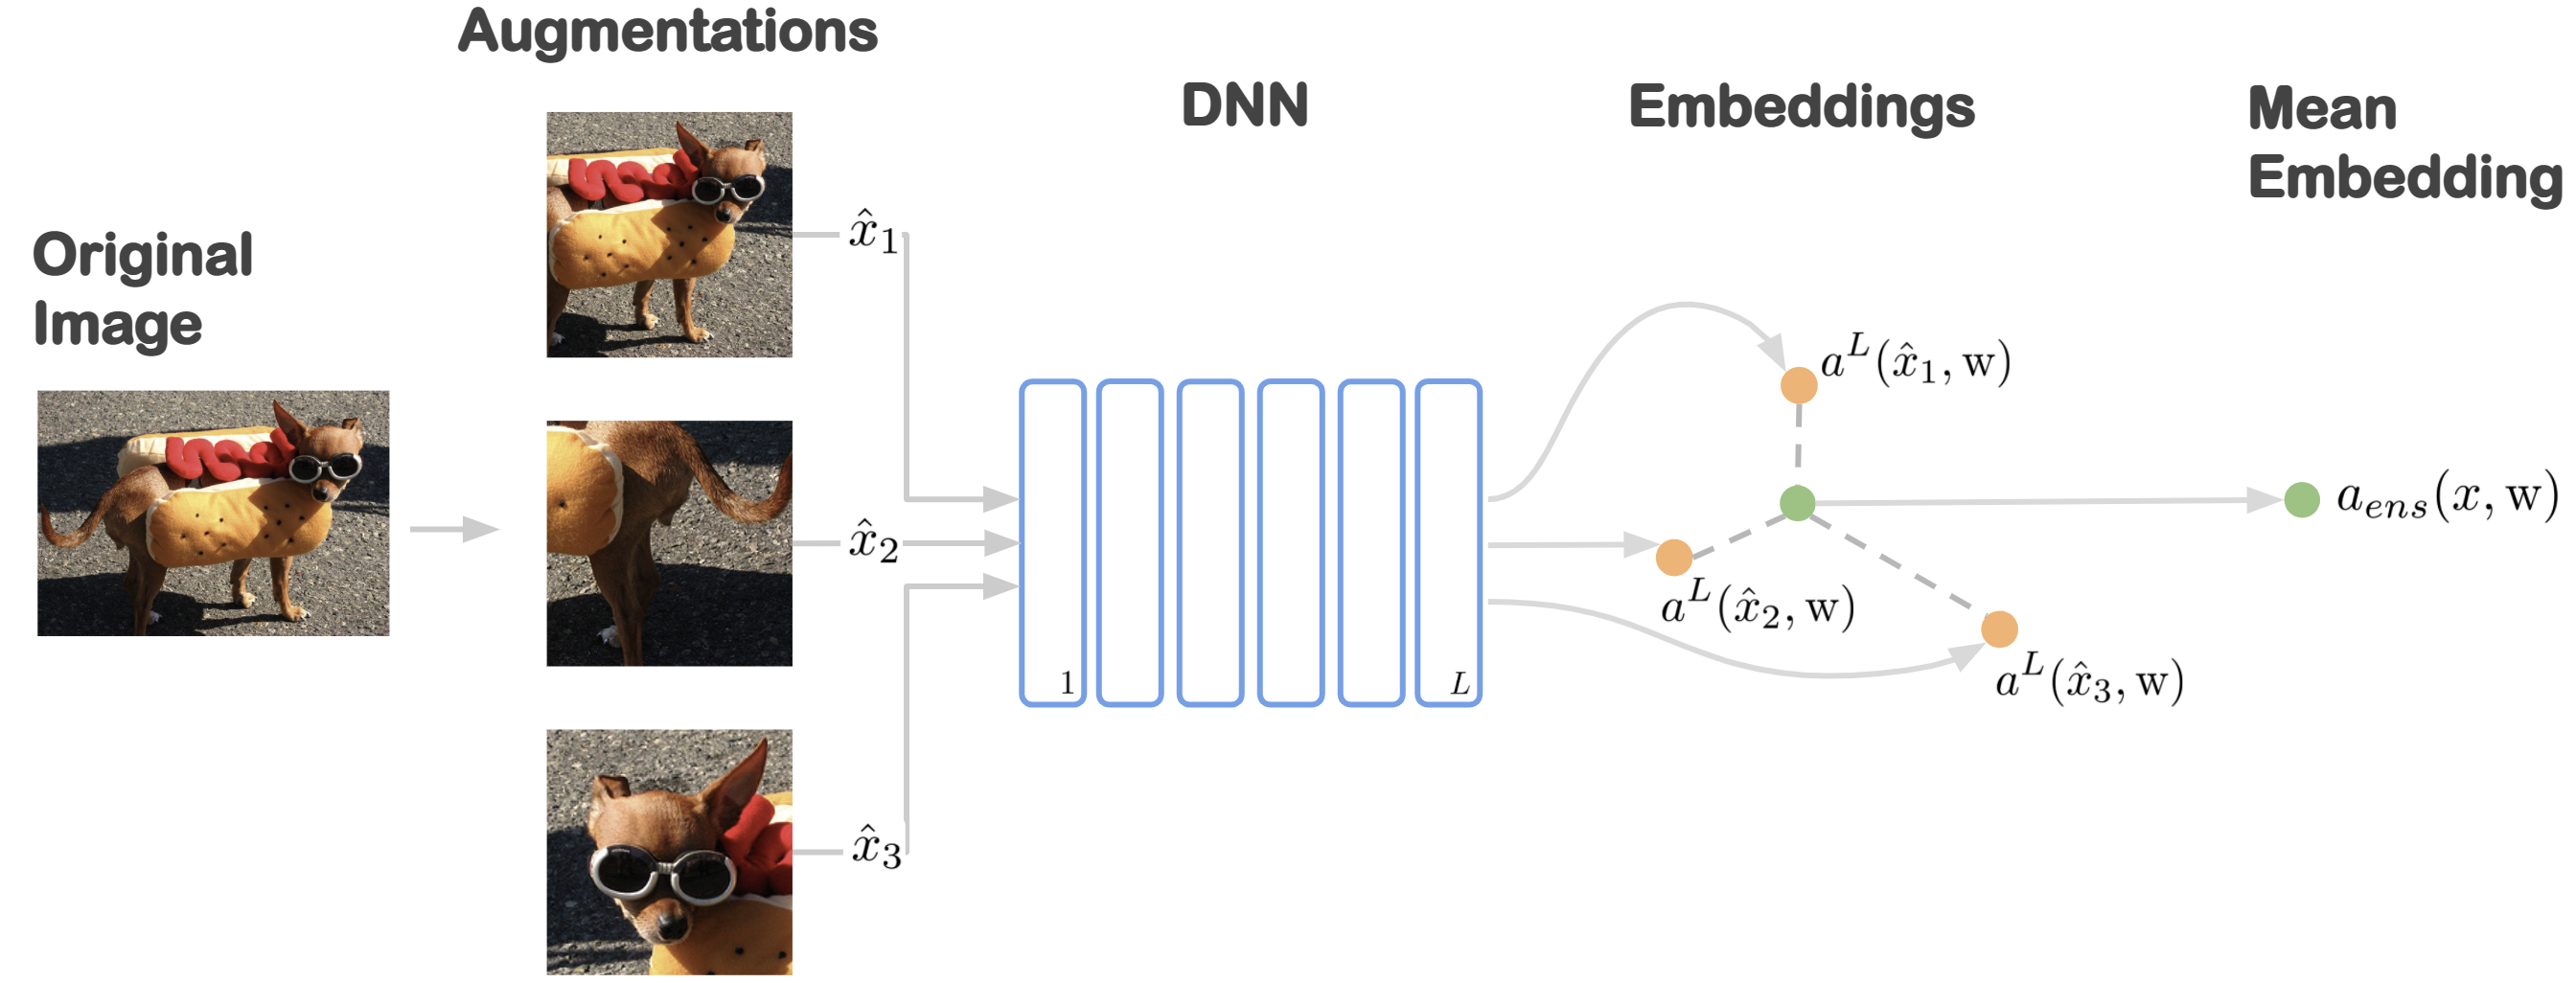

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


transforms.Compose([
                transforms.RandomResizedCrop(32),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=2)


test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=2)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net = Net()
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)



train_loss = []
train_acc = []
test_acc = []

# Train the model
for epoch in range(50):

    running_loss = 0.0
    total = 0
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item() * inputs.shape[0]
        total += inputs.shape[0]


    print(f'Epoch[{epoch}/50]: Training Loss  {running_loss / total:.3f}')
    train_loss.append(running_loss / total)

    # Calculate train acc
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.shape[0]
            correct += (predicted == labels).sum().item()

    print(f'Epoch[{epoch}/50]: Training Acc  {100 * correct / total:.3f} %')
    train_acc.append(100 * correct / total)

    # Calculate test acc
    correct = 0
    total = 0
    num_repeats = 10

    with torch.no_grad():
        for data in testloader:

            images, labels = data
            labels = labels.to(device, non_blocking=True)

            avg_output = 0

            for iter in range(num_repeats):
                aug_images = transforms.RandomResizedCrop(32)(images)
                aug_images = transforms.RandomHorizontalFlip()(aug_images)
                aug_images = aug_images.to(device, non_blocking=True)

                outputs = net(aug_images)
                outputs = F.softmax(outputs)
                # print(outputs)
                avg_output += outputs

            avg_output /= num_repeats
            _, predicted = torch.max(avg_output.data, 1)
            total += labels.shape[0]
            correct += (predicted == labels).sum().item()

    print(f'Epoch[{epoch}/50]: Test Acc  {100 * correct / total:.3f} %')
    test_acc.append(100 * correct / total)

print('Finished Training')

# save model

torch.save({
    "model": net.state_dict(),
    "loss": np.array(train_loss),
    "train_acc": np.array(train_acc),
    "test_acc": np.array(test_acc)
    }, "./cifar_10_data_aug_ensemble_bs_256_lr_0.001.pth")

Files already downloaded and verified
Files already downloaded and verified
Epoch[0/50]: Training Loss  2.303
Epoch[0/50]: Training Acc  11.176 %


/tmp/ipykernel_3605305/3199873712.py:101: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = torch.nn.functional.softmax(outputs)


Epoch[0/50]: Test Acc  10.800 %
Epoch[1/50]: Training Loss  2.299
Epoch[1/50]: Training Acc  13.476 %
Epoch[1/50]: Test Acc  15.090 %
Epoch[2/50]: Training Loss  2.289
Epoch[2/50]: Training Acc  18.034 %
Epoch[2/50]: Test Acc  18.970 %
Epoch[3/50]: Training Loss  2.257
Epoch[3/50]: Training Acc  17.652 %
Epoch[3/50]: Test Acc  17.340 %
Epoch[4/50]: Training Loss  2.183
Epoch[4/50]: Training Acc  21.616 %
Epoch[4/50]: Test Acc  21.270 %
Epoch[5/50]: Training Loss  2.081
Epoch[5/50]: Training Acc  24.618 %
Epoch[5/50]: Test Acc  23.980 %
Epoch[6/50]: Training Loss  2.002
Epoch[6/50]: Training Acc  26.858 %
Epoch[6/50]: Test Acc  24.720 %
Epoch[7/50]: Training Loss  1.935
Epoch[7/50]: Training Acc  29.676 %
Epoch[7/50]: Test Acc  27.840 %
Epoch[8/50]: Training Loss  1.865
Epoch[8/50]: Training Acc  32.676 %
Epoch[8/50]: Test Acc  30.650 %
Epoch[9/50]: Training Loss  1.804
Epoch[9/50]: Training Acc  34.672 %
Epoch[9/50]: Test Acc  32.550 %
Epoch[10/50]: Training Loss  1.758
Epoch[10/50]: T

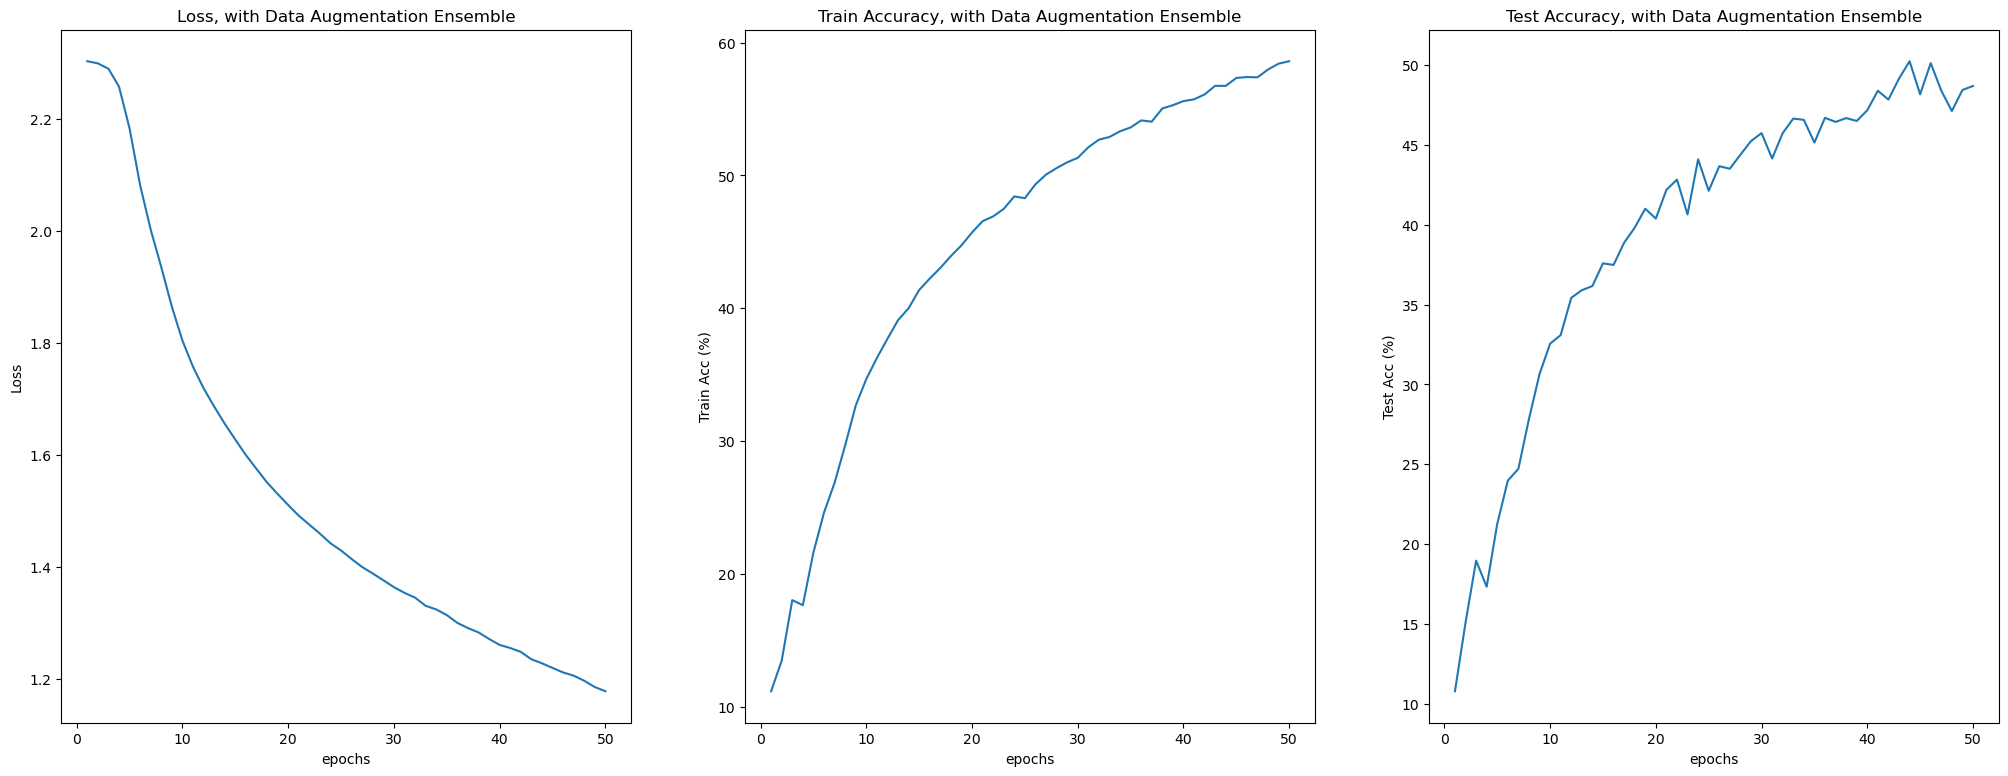

In [ ]:
epochs = [i for i in range(1, 51)]
ckpt = torch.load("cifar_10_data_aug_ensemble_bs_256_lr_0.001.pth")
train_loss = ckpt["loss"]
train_acc = ckpt["train_acc"]
test_acc = ckpt["test_acc"]

fig, (ax_loss, ax_train_acc, ax_test_acc) = plt.subplots(nrows=1, ncols=3, figsize=(25, 9))
ax_loss.plot(epochs, train_loss)
ax_loss.set_title("Loss, with Data Augmentation Ensemble")
ax_loss.set_xlabel("epochs")
ax_loss.set_ylabel("Loss")

ax_train_acc.plot(epochs, train_acc)
ax_train_acc.set_title("Train Accuracy, with Data Augmentation Ensemble")
ax_train_acc.set_xlabel("epochs")
ax_train_acc.set_ylabel("Train Acc (%)")

ax_test_acc.plot(epochs, test_acc)
ax_test_acc.set_title("Test Accuracy, with Data Augmentation Ensemble")
ax_test_acc.set_xlabel("epochs")
ax_test_acc.set_ylabel("Test Acc (%)")

plt.show()

### Ensemble with drop-out

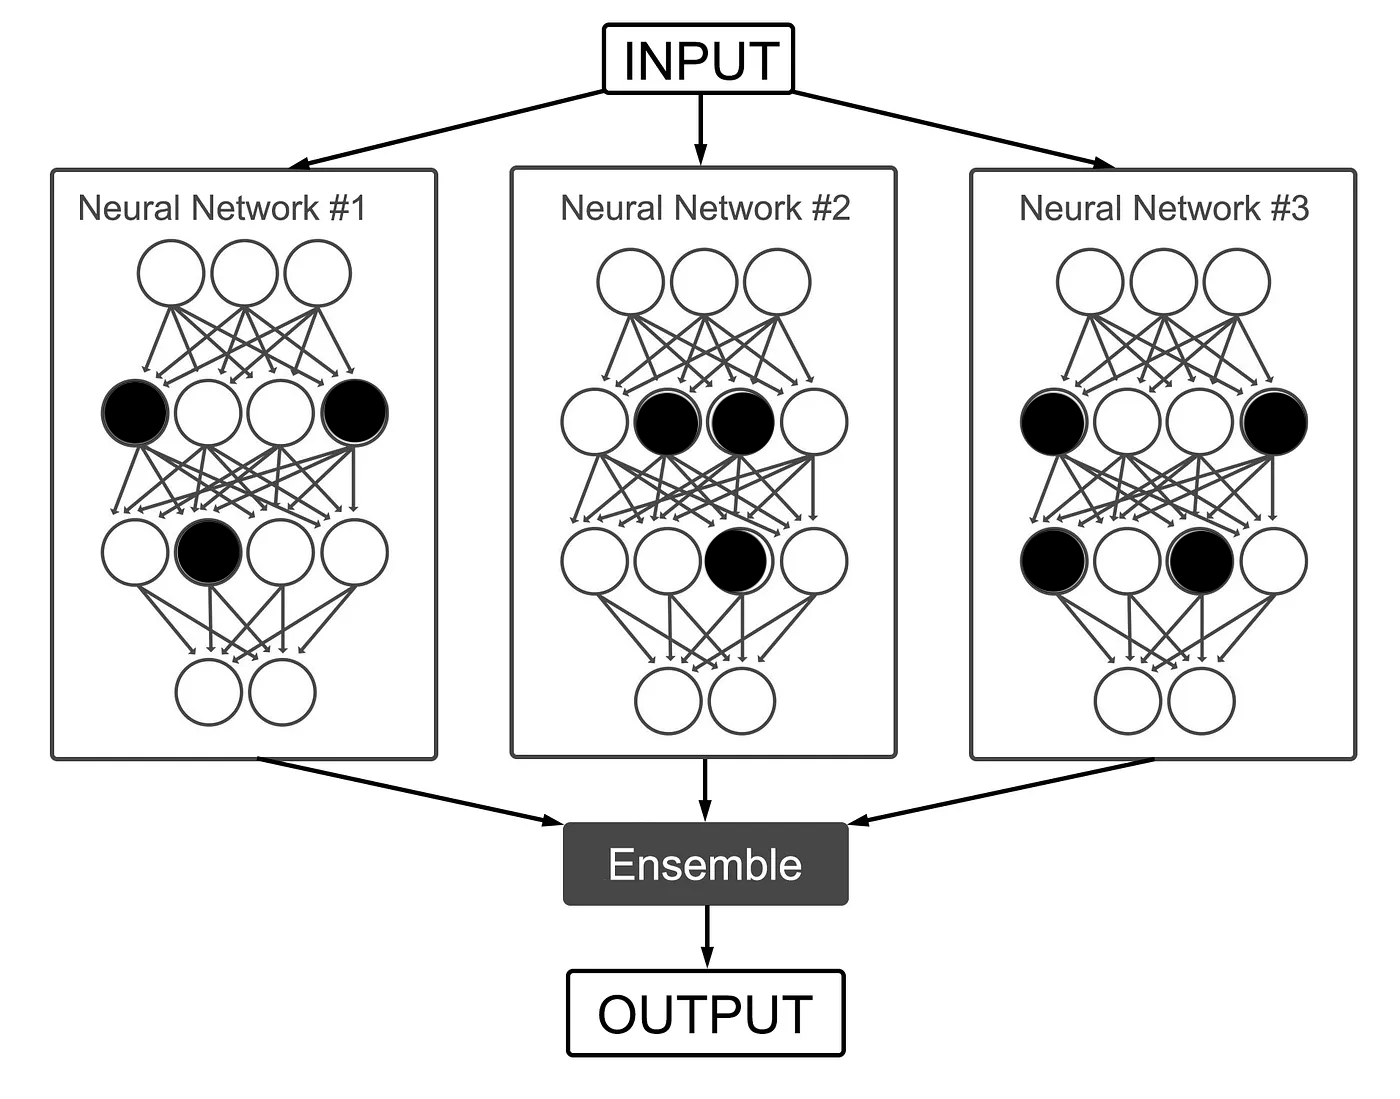

In [ ]:
class Net_w_Dropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x, dropout_p=0):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.dropout(F.relu(self.fc1(x)), p=dropout_p)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
transforms.Compose([
                transforms.RandomResizedCrop(32),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=2)

test_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=2)


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net = Net_w_Dropout()
net = net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)



train_loss = []
train_acc = []
test_acc = []

# Train the model
for epoch in range(50):

    running_loss = 0.0
    total = 0
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item() * inputs.shape[0]
        total += inputs.shape[0]


    print(f'Epoch[{epoch}/50]: Training Loss  {running_loss / total:.3f}')
    train_loss.append(running_loss / total)

    # Calculate train acc
    correct = 0
    total = 0
    with torch.no_grad():
        for data in trainloader:
            images, labels = data
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.shape[0]
            correct += (predicted == labels).sum().item()

    print(f'Epoch[{epoch}/50]: Training Acc  {100 * correct / total:.3f} %')
    train_acc.append(100 * correct / total)

    # Calculate test acc
    correct = 0
    total = 0
    num_repeats = 10

    with torch.no_grad():
        for data in testloader:

            images, labels = data
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            avg_output = 0

            for iter in range(num_repeats):

                outputs = net(images, dropout_p=0.5)
                outputs = F.softmax(outputs)
                # print(outputs)
                avg_output += outputs

            avg_output /= num_repeats
            _, predicted = torch.max(avg_output.data, 1)
            total += labels.shape[0]
            correct += (predicted == labels).sum().item()

    print(f'Epoch[{epoch}/50]: Test Acc  {100 * correct / total:.3f} %')
    test_acc.append(100 * correct / total)

print('Finished Training')

# save model

torch.save({
    "model": net.state_dict(),
    "loss": np.array(train_loss),
    "train_acc": np.array(train_acc),
    "test_acc": np.array(test_acc)
    }, "./cifar_10_dropout_bs_256_lr_0.001.pth")

Files already downloaded and verified
Epoch[0/50]: Training Loss  2.304
Epoch[0/50]: Training Acc  11.184 %


/tmp/ipykernel_3605305/1845165155.py:90: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(outputs)


Epoch[0/50]: Test Acc  11.330 %
Epoch[1/50]: Training Loss  2.300
Epoch[1/50]: Training Acc  12.168 %
Epoch[1/50]: Test Acc  11.960 %
Epoch[2/50]: Training Loss  2.294
Epoch[2/50]: Training Acc  13.720 %
Epoch[2/50]: Test Acc  13.130 %
Epoch[3/50]: Training Loss  2.280
Epoch[3/50]: Training Acc  17.736 %
Epoch[3/50]: Test Acc  18.240 %
Epoch[4/50]: Training Loss  2.242
Epoch[4/50]: Training Acc  20.142 %
Epoch[4/50]: Test Acc  21.270 %
Epoch[5/50]: Training Loss  2.147
Epoch[5/50]: Training Acc  25.126 %
Epoch[5/50]: Test Acc  23.360 %
Epoch[6/50]: Training Loss  2.072
Epoch[6/50]: Training Acc  26.992 %
Epoch[6/50]: Test Acc  25.500 %
Epoch[7/50]: Training Loss  2.025
Epoch[7/50]: Training Acc  27.912 %
Epoch[7/50]: Test Acc  25.240 %
Epoch[8/50]: Training Loss  1.985
Epoch[8/50]: Training Acc  29.450 %
Epoch[8/50]: Test Acc  27.800 %
Epoch[9/50]: Training Loss  1.947
Epoch[9/50]: Training Acc  30.966 %
Epoch[9/50]: Test Acc  28.500 %
Epoch[10/50]: Training Loss  1.912
Epoch[10/50]: T

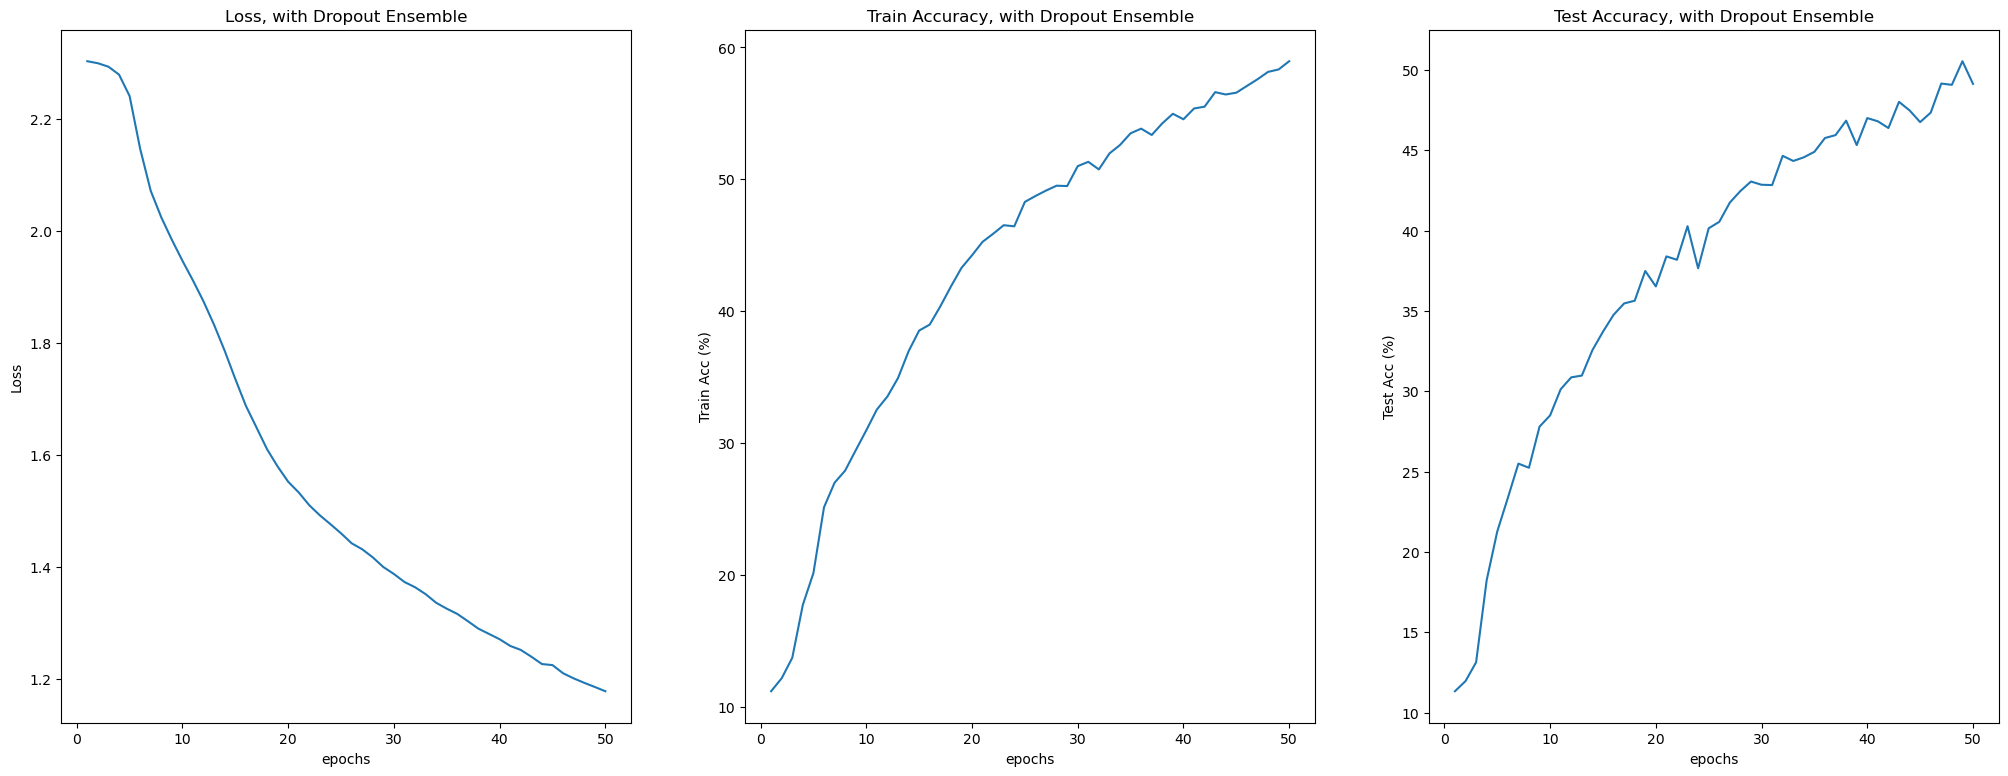

In [ ]:
epochs = [i for i in range(1, 51)]
ckpt = torch.load("cifar_10_dropout_bs_256_lr_0.001.pth")
train_loss = ckpt["loss"]
train_acc = ckpt["train_acc"]
test_acc = ckpt["test_acc"]

fig, (ax_loss, ax_train_acc, ax_test_acc) = plt.subplots(nrows=1, ncols=3, figsize=(25, 9))
ax_loss.plot(epochs, train_loss)
ax_loss.set_title("Loss, with Dropout Ensemble")
ax_loss.set_xlabel("epochs")
ax_loss.set_ylabel("Loss")

ax_train_acc.plot(epochs, train_acc)
ax_train_acc.set_title("Train Accuracy, with Dropout Ensemble")
ax_train_acc.set_xlabel("epochs")
ax_train_acc.set_ylabel("Train Acc (%)")

ax_test_acc.plot(epochs, test_acc)
ax_test_acc.set_title("Test Accuracy, with Dropout Ensemble")
ax_test_acc.set_xlabel("epochs")
ax_test_acc.set_ylabel("Test Acc (%)")

plt.show()